# High angular resolution diffusion imaging

In this example we will compute the signal using the same gradient sequence in many
different directions.

## Building a biological model

We start by loading SpinDoctor and a Makie plotting backend.

In [1]:
using SpinDoctor
using LinearAlgebra

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

Here we create a recipe for five stacked plates with isotropic diffusion tensors. They
should allow for free diffusion in the horizontal direction, but a rather restricted
vertical diffusion with the permeable membranes.

In [2]:
ncell = 5
setup = PlateSetup(;
    name = "Plates",
    width = 50.0,
    depth = 50.0,
    heights = fill(5.0, ncell),
    bend = 0.0,
    twist = 0.0,
)
coeffs = coefficients(
    setup;
    D = [0.002 * I(3) for _ = 1:ncell],
    T₂ = fill(Inf, ncell),
    ρ = fill(1.0, ncell),
    κ = (; interfaces = fill(1e-4, ncell - 1), boundaries = fill(0.0, ncell)),
    γ = 2.67513e-4,
)

(D = StaticArrays.SMatrix{3, 3, Float64, 9}[[0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002]], T₂ = [Inf, Inf, Inf, Inf, Inf], κ = [0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0], ρ = ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], γ = 0.000267513)

We then proceed to build the geometry and finite element mesh.

[ Info: Saving mesh in Tetgen output format at meshfiles/Plates_dir/Plates_mesh.1


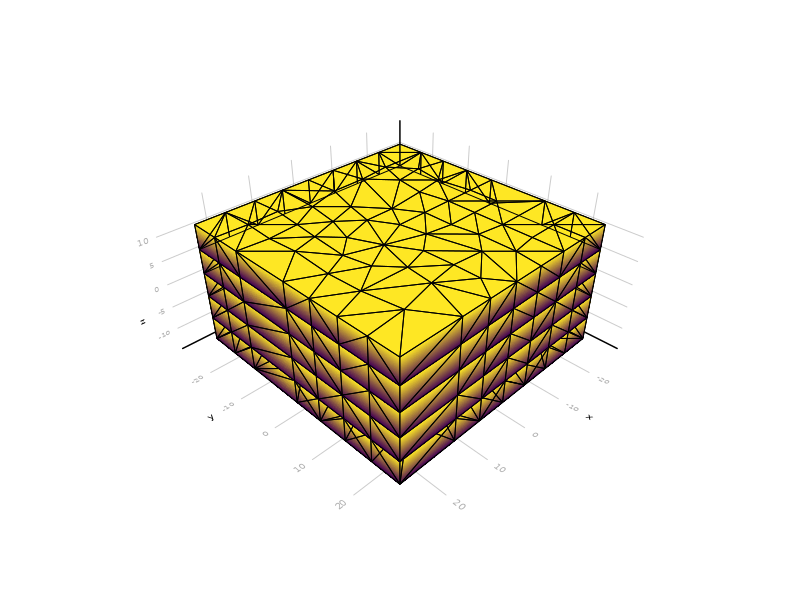

In [3]:
mesh, = create_geometry(setup; recreate = true)
plot_mesh(mesh)

The mesh looks good, so we may then proceed to assemble the biological model and the
associated finite element matrices.

In [4]:
model = Model(; mesh, coeffs...)
matrices = assemble_matrices(model);

We may also compute some useful quantities, including a scalar diffusion coefficient from
the diffusion tensors.

In [5]:
volumes = get_cmpt_volumes(model.mesh)
D_avg = 1 / 3 * tr.(model.D)' * volumes / sum(volumes)
ncompartment = length(model.mesh.points)

5

The gradient pulse sequence will be a PGSE with both vertical and horizontal components.
This allows for both restricted vertical diffusion and almost unrestricted horizontal
diffusion. The different approaches should hopefully confirm this behaviour.

In [6]:
directions = unitsphere(200)
profile = PGSE(2500.0, 4000.0)
b = 1000
g = √(b / int_F²(profile)) / model.γ
gradients = [ScalarGradient(d, profile, g) for d ∈ eachcol(directions)]

200-element Vector{ScalarGradient{Float64}}:
 ScalarGradient{Float64}([0.09987492177719094, 0.0, 0.995], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([-0.12723619955312943, -0.11655878140782122, 0.985], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([0.01942642095897662, 0.2213540471026556, 0.975], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([0.1595630187894423, -0.20812170245988318, 0.965], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([-0.2920717300973464, 0.051663376563509125, 0.955], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([0.2759673217251014, 0.17554782066398444, 0.945], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([-0.09206807289524455, -0.3424886420793481, 0.935], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
 ScalarGradient{Float64}([-0.17512950731951155, 0.33720120946702586, 0.925], PGS

We may solve the BTPDE for each gradient.

In [7]:
btpde = BTPDE(; model, matrices)
solver = IntervalConstantSolver(; timestep = 10.0)
ξ, = solve_multigrad(btpde, gradients, solver)

┌ Info: Solving
└   typeof(problem) = BTPDE{Float64}
[ Info: ScalarGradient{Float64}([0.09987492177719094, 0.0, 0.995], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([-0.12723619955312943, -0.11655878140782122, 0.985], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([0.01942642095897662, 0.2213540471026556, 0.975], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([0.1595630187894423, -0.20812170245988318, 0.965], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([-0.2920717300973464, 0.051663376563509125, 0.955], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([0.2759673217251014, 0.17554782066398444, 0.945], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{Float64}([-0.09206807289524455, -0.3424886420793481, 0.935], PGSE{Float64}(2500.0, 4000.0), 0.8402604538082508)
[ Info: ScalarGradient{

(Vector{ComplexF64}[[0.6227896975801076 - 0.4564425067098879im, 0.6983070659930033 - 0.29076853753509563im, 0.7003953243215352 - 0.3068226527476778im, 0.6401711994884943 - 0.44850059257598957im, 0.6383540038931967 + 0.12784091220660632im, 0.5932565277244367 + 0.27239216272169225im, 0.5986966449565657 + 0.22676375724628559im, 0.632178137520047 + 0.10160080030107833im, 0.6242891768982607 + 0.24032277651105907im, 0.6289561810692751 - 0.39568141618346797im  …  0.6318126783580558 - 0.23924159083310462im, 0.6495905622048437 + 0.3675569969504086im, 0.6090617897184404 - 0.3441784144307195im, 0.6646909984807126 + 0.34183071820827626im, 0.6397885593914696 + 0.3710115349488386im, 0.6544471426963221 + 0.36300772049946095im, 0.6327838807055977 + 0.37685175749137384im, 0.6358778846067753 + 0.37273095432938486im, 0.6251721210375201 - 0.22436755941787914im, 0.6611719194485911 + 0.36178899774626005im], [0.7132975597579255 - 0.16746886657870858im, 0.6490416466325573 - 0.3693038153085283im, 0.59238918126

The signals are computed from the magnetization field through quadrature.

In [8]:
signal = [abs(compute_signal(matrices.M, ξ)) for ξ ∈ ξ]

200-element Vector{Float64}:
 37005.69382048703
 35966.4960565195
 35014.66774308326
 34024.49860540044
 33010.40745768582
 32061.884305437685
 31014.29472338982
 30046.387818877425
 29121.30322784354
 28132.295633439513
     ⋮
 29100.968567566288
 30066.695930583362
 31061.488707143013
 32018.717464737216
 33064.13621779007
 33958.6314170913
 35013.12923302178
 36013.28738028371
 36978.95607169844

We may plot the directionalized signal.

Delaunizing vertices...
Delaunay seconds:  0.010207
Creating surface mesh ...
Surface mesh seconds:  0.001268
Constrained Delaunay...
Constrained Delaunay seconds:  0.001836
Removing exterior tetrahedra ...
Spreading region attributes.
Exterior tets removal seconds:  0.000187
Refining mesh...
Refinement seconds:  0.013367
Optimizing mesh...
Optimization seconds:  0.000556

Writing nodes.
Writing elements.
Writing faces.
Writing edges.

Output seconds:  0.000121
Total running seconds:  0.027601

Statistics:

  Input points: 344
  Input facets: 912
  Input segments: 516
  Input holes: 0
  Input regions: 4

  Mesh points: 616
  Mesh tetrahedra: 1709
  Mesh faces: 4032
  Mesh faces on exterior boundary: 1228
  Mesh faces on input facets: 1456
  Mesh edges on input segments: 550
  Steiner points on input facets:  238
  Steiner points on input segments:  34

Delaunizing vertices...
Delaunay seconds:  0.000197
Creating surface mesh ...
Surface mesh seconds:  9.1e-05
Constrained Delaunay...
Co

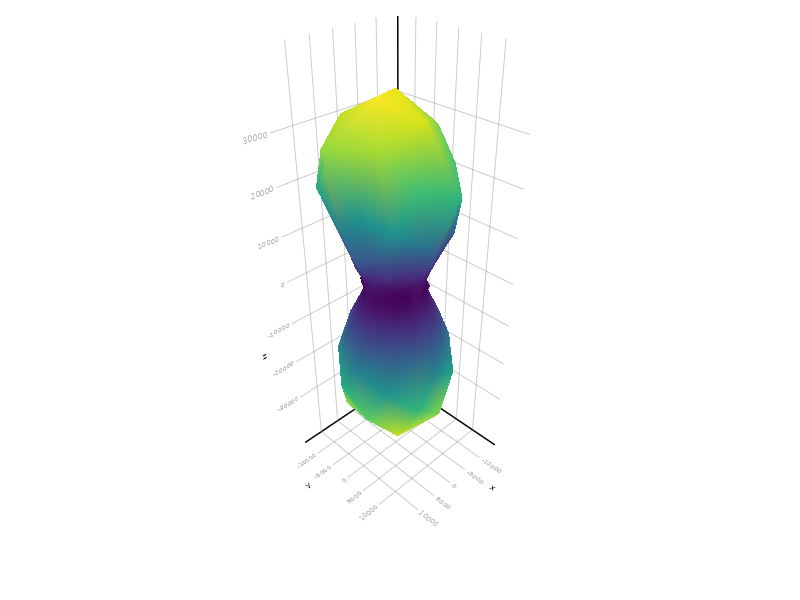

In [9]:
plot_hardi(directions, signal)

The signal attenuates the most in the horizontal direction, as that is where diffusion is
restricted the least.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*